In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from emely import mle_fit

In [2]:
# define plot style
violet = "#785ef0"
blue = "#648fff"
yellow = "#ffb000"
orange = "#fe6100"
red = "#dc267f"
black = "000000"
gray = "cccccc"
white = "ffffff"

plt.style.use("seaborn-v0_8")

The goal is to estimate the parameters $a$, $\mu$, and $\sigma$ of a normalized Gaussian function:

$
f(x) = \frac{a}{\sqrt{2\pi\,\sigma^2}} \, e^{-\frac{(x - \mu)^2}{2\sigma^2}}
$

from measurements

$
y(x) = f(x) + \varepsilon
$

where the noise term $ \varepsilon $ follows **Poisson statistics**. 

This setup represents, for example, an experiment aiming to determine the center and width of a Gaussian point-spread function (PSF) from photon-counting data. Here, the total number of detected photons would be $a = N_\mathrm{ph} \cdot \Delta x$, where $ \Delta x $ is the sampling period.

In these scenarios, least-squares optimization is not optimal because it assumes that the noise follows Gaussian statistics.  
Instead, it is more appropriate to use **maximum likelihood estimation (MLE)** formulated for **Poisson noise**. This becomes particularly relevant if the number of detected photons is low.

Here, we demonstrate how the Emely package can be used to perform parameter estimation using MLE.

In [3]:
# define the model to fit
def gaussian(x, a, mu, sigma):
    return a / np.sqrt(2 * np.pi * sigma**2) * np.exp(-((x - mu) ** 2) / (2 * sigma**2))

In [4]:
# define estimators
estimators = {
    "Least-Squares": lambda f,
    xdata,
    ydata,
    p0,
    bounds,
    sigma,
    absolute_sigma: curve_fit(
        f,
        xdata,
        ydata,
        p0=p0,
        bounds=bounds,
        sigma=sigma,
        absolute_sigma=absolute_sigma,
    ),
    "Gaussian-MLE": lambda f, xdata, ydata, p0, bounds, sigma, absolute_sigma: mle_fit(
        f,
        xdata,
        ydata,
        p0=p0,
        bounds=bounds,
        sigma=sigma,
        absolute_sigma=absolute_sigma,
        noise_type="gaussian",
    ),
    "Poisson-MLE": lambda f, xdata, ydata, p0, bounds, sigma, absolute_sigma: mle_fit(
        f,
        xdata,
        ydata,
        p0=p0,
        bounds=bounds,
        sigma=sigma,
        absolute_sigma=absolute_sigma,
        noise_type="poisson",
    ),
}

In [ ]:
# define model parameters
dx = 160e-9  # (m)
mu = 0  # (m)
sigma = 300e-9  # (m)
N_ph = 2e1  # number of detected photons
p = (N_ph * dx, mu, sigma)

# define model variables
x_rng = (-3 * sigma, 3 * sigma)
n_x = round((x_rng[1] - x_rng[0]) / dx) + 1
x = x_rng[0] + dx * np.arange(n_x)

# set the random seed
np.random.seed(3)

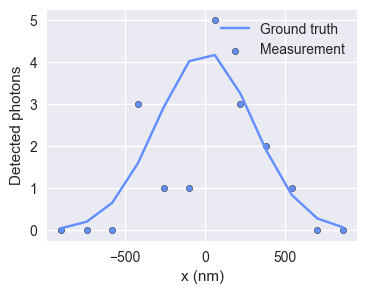

In [6]:
# create the measurement
f_x = gaussian(x, *p)
y_x = np.random.poisson(f_x)

plt.figure(figsize=(4, 3))

plt.plot(1e9 * x, f_x, color=blue, label="Ground truth")
plt.scatter(
    1e9 * x, y_x, color=red, s=20, edgecolor=black, facecolor=blue, label="Measurement"
)

plt.xlabel("x (nm)")
plt.ylabel("Detected photons")
plt.legend()

In [7]:
# define initial guesses
N_ph_0 = np.sum(y_x)
a_0 = N_ph_0 * dx
mu_0 = np.sum(x * y_x) / N_ph_0  # (m)
sigma_0 = np.sqrt(np.sum((x - mu_0) ** 2 * y_x) / N_ph_0)  # (m)
p_0 = (a_0, mu_0, sigma_0)

# define bounds
bounds = (
    [1e-18, -np.inf, 1e-18],
    [np.inf, np.inf, np.inf],
)

In [8]:
# perform parameter estimation using different estimators
p_opt = {}
p_cov = {}
for name in estimators:
    p_opt[name], p_cov[name] = estimators[name](
        gaussian,
        x,
        y_x,
        p0=p_0,
        bounds=bounds,
        sigma=np.sqrt(y_x + 1),
        absolute_sigma=True,
    )

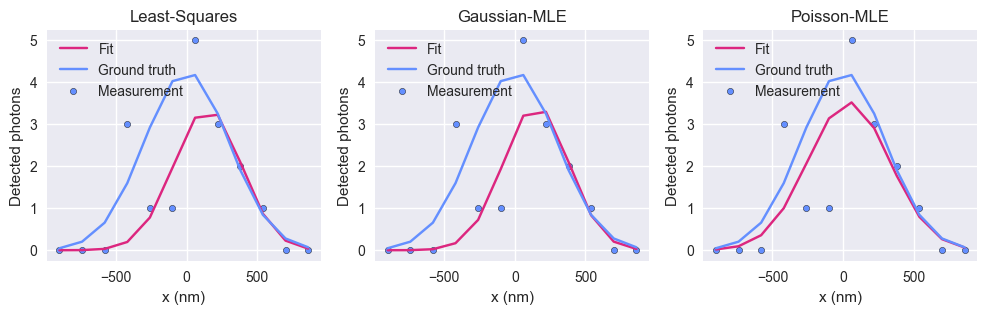

In [9]:
# show the results
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

for ii, name in enumerate(estimators):
    axs[ii].plot(1e9 * x, gaussian(x, *p_opt[name]), color=red, label="Fit")
    axs[ii].plot(1e9 * x, gaussian(x, *p), color=blue, label="Ground truth")
    axs[ii].scatter(
        1e9 * x,
        y_x,
        color=red,
        s=20,
        edgecolor=black,
        facecolor=blue,
        label="Measurement",
    )
    axs[ii].legend()
    axs[ii].set_title(name)

    axs[ii].set_xlabel("x (nm)")
    axs[ii].set_ylabel("Detected photons")
